In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import our custom RDD class
from main import RegressionDiscontinuityDesign

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("✅ All imports successful!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All imports successful!
Pandas version: 2.3.0
NumPy version: 1.26.4


In [2]:
def generate_doordash_rdd_data(n=3000):
    """
    Generate realistic DoorDash customer data for RDD analysis
    
    Business Scenario: DoorDash implements an automatic DashPass enrollment policy:
    - Customers with 50+ lifetime orders automatically get DashPass
    - This creates a sharp discontinuity at exactly 50 orders
    - We want to measure the causal impact on monthly ordering behavior
    
    This is a perfect RDD setup because:
    1. Sharp cutoff rule (>=50 orders)
    2. Running variable hard to manipulate (past orders are fixed)
    3. Clear policy rationale
    4. Measurable outcome
    """
    
    print("🏪 Generating DoorDash RDD data...")
    print("   Scenario: Auto-DashPass enrollment at 50+ lifetime orders")
    
    data = []
    
    for customer_id in range(n):
        
        # RUNNING VARIABLE: Lifetime previous orders
        # Most customers naturally distributed, but some might try to manipulate
        
        if np.random.random() < 0.03:  # 3% attempt manipulation near cutoff
            # These customers might place extra orders to reach 50
            previous_orders = np.random.normal(52, 1.5)  # Bunch just above cutoff
        else:
            # Natural exponential distribution (realistic for order counts)
            previous_orders = np.random.exponential(30)
            
        # Ensure realistic bounds
        previous_orders = max(0, min(previous_orders, 200))
        previous_orders = round(previous_orders)
        
        # CUSTOMER CHARACTERISTICS (potential confounders)
        age = np.clip(np.random.normal(35, 12), 18, 75)
        income = max(25000, np.random.normal(60000, 25000))
        is_urban = np.random.binomial(1, 0.65)
        has_kids = np.random.binomial(1, 0.35)
        app_tenure_months = max(1, np.random.exponential(18))
        
        # Customer type affects baseline ordering
        is_frequent_orderer = previous_orders > np.percentile(range(n), 75)
        price_sensitivity = np.random.beta(2, 2)  # 0-1 scale
        
        # TREATMENT ASSIGNMENT: Sharp RDD at 50 orders
        cutoff = 50
        auto_enrolled_dashpass = 1 if previous_orders >= cutoff else 0
        
        # In practice, there might be some fuzziness (opt-outs, manual enrollments)
        # But for sharp RDD, we'll use the deterministic rule
        has_dashpass = auto_enrolled_dashpass
        
        # OUTCOME: Current month order frequency
        # Base ordering depends on customer characteristics
        base_monthly_orders = (
            2.0 +  # Baseline
            0.00002 * income +  # Income effect
            0.03 * min(previous_orders, 49) +  # Past behavior (capped at cutoff-1)
            1.2 * is_urban +  # Urban convenience
            0.8 * has_kids +  # Family ordering
            0.1 * app_tenure_months +  # Experience with app
            -1.5 * price_sensitivity +  # Price sensitive order less
            np.random.normal(0, 1.5)  # Individual variation
        )
        
        # RDD TREATMENT EFFECT: DashPass impact
        # Key insight: There should be a SHARP JUMP at exactly 50 orders
        # due to automatic DashPass enrollment
        
        rdd_treatment_effect = 0
        if previous_orders >= cutoff:
            # DashPass effect: free delivery → more orders
            base_effect = 3.2  # Average effect
            
            # Heterogeneous effects
            urban_bonus = 0.8 if is_urban else 0  # Urban customers benefit more
            price_sensitive_bonus = price_sensitivity * 1.5  # Price sensitive benefit more
            
            rdd_treatment_effect = (
                base_effect + 
                urban_bonus + 
                price_sensitive_bonus + 
                np.random.normal(0, 0.6)  # Individual variation
            )
            
        # Final outcome
        monthly_orders = max(0, base_monthly_orders + rdd_treatment_effect)
        
        # Additional outcomes for robustness checks
        avg_order_value = (
            23 + 
            0.0001 * income + 
            (2 if has_dashpass else 0) +  # DashPass → slightly higher AOV
            np.random.normal(0, 3)
        )
        
        customer_satisfaction = (
            3.8 + 
            (0.3 if has_dashpass else 0) +  # DashPass → better experience
            np.random.normal(0, 0.4)
        )
        customer_satisfaction = np.clip(customer_satisfaction, 1, 5)
        
        data.append({
            'customer_id': customer_id,
            
            # RUNNING VARIABLE
            'lifetime_orders': previous_orders,
            
            # TREATMENT 
            'has_dashpass': has_dashpass,
            'auto_enrolled': auto_enrolled_dashpass,
            
            # PRIMARY OUTCOME
            'monthly_orders': round(monthly_orders, 1),
            
            # CUSTOMER CHARACTERISTICS (for balance checks)
            'age': round(age, 1),
            'income': round(income, 0),
            'is_urban': is_urban,
            'has_kids': has_kids,
            'app_tenure_months': round(app_tenure_months, 1),
            'price_sensitivity': round(price_sensitivity, 2),
            
            # ADDITIONAL OUTCOMES (for robustness)
            'avg_order_value': round(avg_order_value, 2),
            'customer_satisfaction': round(customer_satisfaction, 1),
            
            # GROUND TRUTH (for evaluation)
            'true_rdd_effect': round(rdd_treatment_effect, 2)
        })
    
    df = pd.DataFrame(data)
    
    print(f"✅ Generated {len(df):,} customer records")
    print(f"   Running variable range: {df['lifetime_orders'].min():.0f} - {df['lifetime_orders'].max():.0f}")
    print(f"   Cutoff: 50 lifetime orders")
    print(f"   Customers above cutoff: {(df['lifetime_orders'] >= 50).sum():,} ({(df['lifetime_orders'] >= 50).mean()*100:.1f}%)")
    print(f"   DashPass enrollment rate: {df['has_dashpass'].mean()*100:.1f}%")
    
    return df

# Generate the dataset
print("🏪 GENERATING DOORDASH RDD DATA")
print("=" * 50)

df = generate_doordash_rdd_data(n=3000)

print(f"\n📊 Dataset Summary:")
print(f"  • Total customers: {len(df):,}")
print(f"  • Running variable: lifetime_orders (range: {df['lifetime_orders'].min():.0f}-{df['lifetime_orders'].max():.0f})")
print(f"  • Treatment cutoff: 50 orders")
print(f"  • Primary outcome: monthly_orders")

🏪 GENERATING DOORDASH RDD DATA
🏪 Generating DoorDash RDD data...
   Scenario: Auto-DashPass enrollment at 50+ lifetime orders
✅ Generated 3,000 customer records
   Running variable range: 0 - 200
   Cutoff: 50 lifetime orders
   Customers above cutoff: 614 (20.5%)
   DashPass enrollment rate: 20.5%

📊 Dataset Summary:
  • Total customers: 3,000
  • Running variable: lifetime_orders (range: 0-200)
  • Treatment cutoff: 50 orders
  • Primary outcome: monthly_orders


📊 DATA EXPLORATION
🔍 Data around cutoff (±10 orders):
  • Observations: 459
  • Below cutoff (40-49): 232
  • At/above cutoff (50-60): 227

🚨 NAIVE COMPARISON (Biased!):
  • Mean orders below cutoff: 5.95
  • Mean orders above cutoff: 11.14
  • Naive difference: +5.19 orders/month
  ⚠️ This is BIASED because high-order customers are different!

📈 VISUALIZING THE DISCONTINUITY


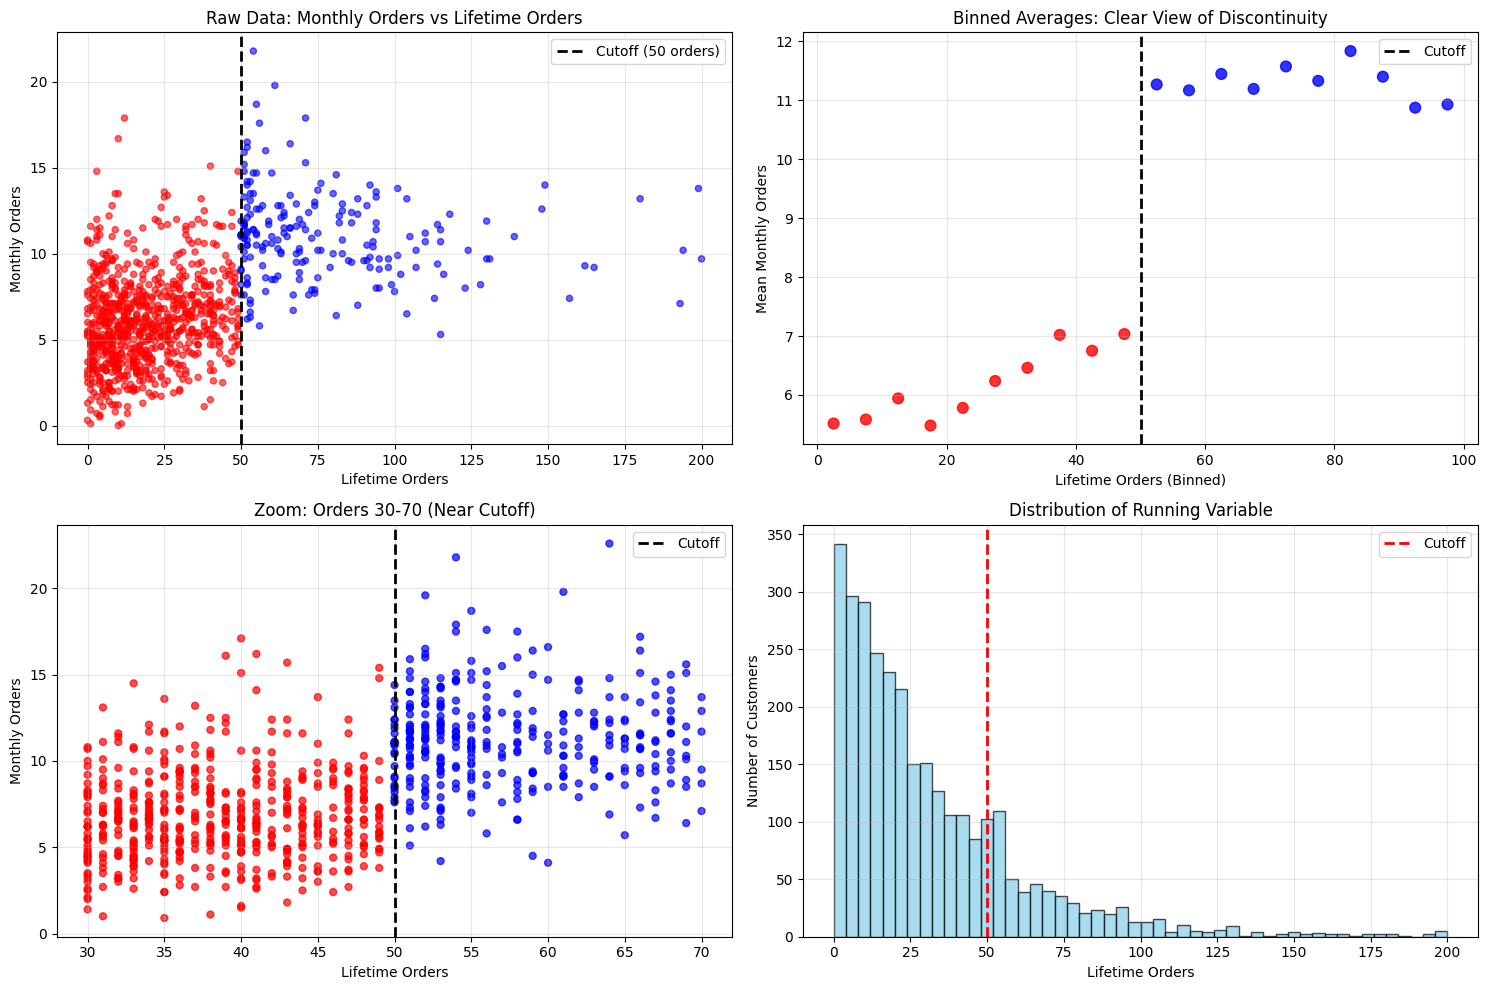

💡 What to look for in these plots:
  1. DISCONTINUOUS JUMP at cutoff (Plot 2 shows this best)
  2. SMOOTH TRENDS on either side of cutoff
  3. NO OBVIOUS MANIPULATION in distribution (Plot 4)
  4. SUFFICIENT DATA around cutoff for estimation


In [3]:
print("📊 DATA EXPLORATION")
print("=" * 50)

# Show basic statistics around the cutoff
cutoff = 50
near_cutoff = df[abs(df['lifetime_orders'] - cutoff) <= 10].copy()

print("🔍 Data around cutoff (±10 orders):")
print(f"  • Observations: {len(near_cutoff):,}")
print(f"  • Below cutoff (40-49): {((near_cutoff['lifetime_orders'] >= 40) & (near_cutoff['lifetime_orders'] < 50)).sum():,}")
print(f"  • At/above cutoff (50-60): {((near_cutoff['lifetime_orders'] >= 50) & (near_cutoff['lifetime_orders'] <= 60)).sum():,}")

# Calculate naive treatment effect
below_cutoff = df[df['lifetime_orders'] < 50]
above_cutoff = df[df['lifetime_orders'] >= 50]

naive_effect = above_cutoff['monthly_orders'].mean() - below_cutoff['monthly_orders'].mean()
print(f"\n🚨 NAIVE COMPARISON (Biased!):")
print(f"  • Mean orders below cutoff: {below_cutoff['monthly_orders'].mean():.2f}")
print(f"  • Mean orders above cutoff: {above_cutoff['monthly_orders'].mean():.2f}")
print(f"  • Naive difference: {naive_effect:+.2f} orders/month")
print(f"  ⚠️ This is BIASED because high-order customers are different!")

# Visualize the potential discontinuity
print(f"\n📈 VISUALIZING THE DISCONTINUITY")
print("=" * 40)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Scatter plot of all data
ax1 = axes[0, 0]
# Sample for plotting to avoid overcrowding
plot_sample = df.sample(min(1000, len(df)), random_state=42)

colors = ['red' if x < 50 else 'blue' for x in plot_sample['lifetime_orders']]
ax1.scatter(plot_sample['lifetime_orders'], plot_sample['monthly_orders'], 
           c=colors, alpha=0.6, s=20)
ax1.axvline(x=50, color='black', linestyle='--', linewidth=2, label='Cutoff (50 orders)')
ax1.set_xlabel('Lifetime Orders')
ax1.set_ylabel('Monthly Orders')
ax1.set_title('Raw Data: Monthly Orders vs Lifetime Orders')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Binned averages for cleaner view
ax2 = axes[0, 1]
# Create bins
bins = range(0, 101, 5)  # 5-order bins
bin_centers = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
bin_means = []

for i in range(len(bins)-1):
    in_bin = (df['lifetime_orders'] >= bins[i]) & (df['lifetime_orders'] < bins[i+1])
    if in_bin.any():
        bin_means.append(df[in_bin]['monthly_orders'].mean())
    else:
        bin_means.append(np.nan)

colors_binned = ['red' if x < 50 else 'blue' for x in bin_centers]
ax2.scatter(bin_centers, bin_means, c=colors_binned, s=60, alpha=0.8)
ax2.axvline(x=50, color='black', linestyle='--', linewidth=2, label='Cutoff')
ax2.set_xlabel('Lifetime Orders (Binned)')
ax2.set_ylabel('Mean Monthly Orders')
ax2.set_title('Binned Averages: Clear View of Discontinuity')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Focus on area around cutoff
ax3 = axes[1, 0]
focus_data = df[(df['lifetime_orders'] >= 30) & (df['lifetime_orders'] <= 70)]
colors_focus = ['red' if x < 50 else 'blue' for x in focus_data['lifetime_orders']]
ax3.scatter(focus_data['lifetime_orders'], focus_data['monthly_orders'], 
           c=colors_focus, alpha=0.7, s=25)
ax3.axvline(x=50, color='black', linestyle='--', linewidth=2, label='Cutoff')
ax3.set_xlabel('Lifetime Orders')
ax3.set_ylabel('Monthly Orders')
ax3.set_title('Zoom: Orders 30-70 (Near Cutoff)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Distribution of running variable
ax4 = axes[1, 1]
ax4.hist(df['lifetime_orders'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax4.axvline(x=50, color='red', linestyle='--', linewidth=2, label='Cutoff')
ax4.set_xlabel('Lifetime Orders')
ax4.set_ylabel('Number of Customers')
ax4.set_title('Distribution of Running Variable')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("💡 What to look for in these plots:")
print("  1. DISCONTINUOUS JUMP at cutoff (Plot 2 shows this best)")
print("  2. SMOOTH TRENDS on either side of cutoff")
print("  3. NO OBVIOUS MANIPULATION in distribution (Plot 4)")
print("  4. SUFFICIENT DATA around cutoff for estimation")

In [4]:
print("🔍 INITIALIZING RDD ANALYSIS")
print("=" * 50)

# Initialize the RDD analysis class
rdd_analysis = RegressionDiscontinuityDesign(
    data=df,
    outcome_var='monthly_orders',    # What we want to measure
    running_var='lifetime_orders',   # Variable that determines treatment
    cutoff=50,                      # Treatment threshold
    treatment_var='has_dashpass'    # Treatment indicator (optional - will be created if not provided)
)

print("✅ RDD analysis object initialized successfully!")
print("📋 Analysis setup:")
print(f"  • Outcome variable: monthly_orders")
print(f"  • Running variable: lifetime_orders") 
print(f"  • Cutoff: 50 orders")
print(f"  • Treatment: has_dashpass (auto-enrollment)")

🔍 INITIALIZING RDD ANALYSIS
✅ RDD data validation passed
  - Total observations: 3,000
  - Running variable range: [0.00, 200.00]
  - Cutoff: 50
  - Treatment units: 614
  - Control units: 2,386
✅ RDD analysis object initialized successfully!
📋 Analysis setup:
  • Outcome variable: monthly_orders
  • Running variable: lifetime_orders
  • Cutoff: 50 orders
  • Treatment: has_dashpass (auto-enrollment)


🔍 ASSUMPTION CHECK 1: DENSITY CONTINUITY (No Manipulation)
This tests whether customers manipulated their order count to cross the cutoff.
If there's manipulation, we'd see a suspicious jump in density right at 50 orders.

ASSUMPTION CHECK: CONTINUITY (NO MANIPULATION)
Density continuity test:
  Density left of cutoff: 101.50
  Density right of cutoff: 95.50
  Ratio (right/left): 0.941
✅ NO OBVIOUS MANIPULATION - density appears continuous

💡 Interpretation:
  ✅ No obvious manipulation detected
  ✅ Density appears continuous across cutoff
  ✅ RDD identification likely valid

📊 Technical Details:
  • Density just below cutoff: 101.5
  • Density just above cutoff: 95.5
  • Ratio (above/below): 0.94


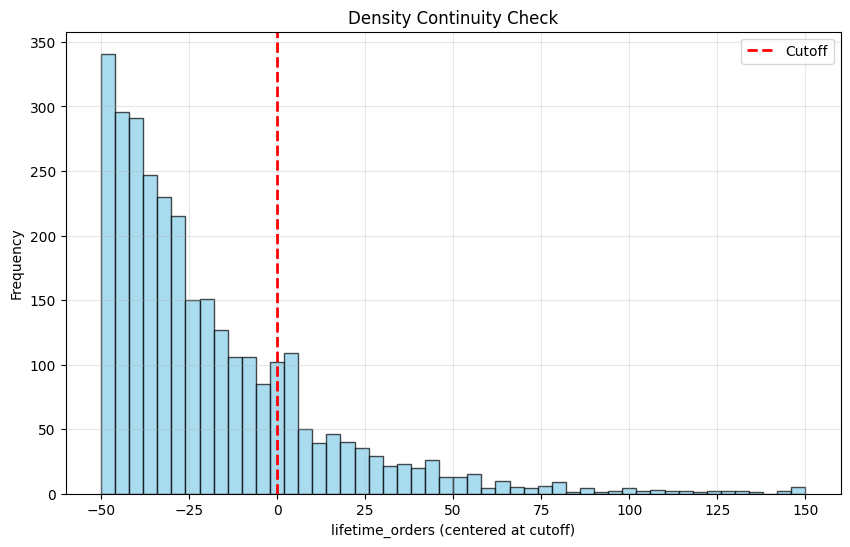

In [5]:
print("🔍 ASSUMPTION CHECK 1: DENSITY CONTINUITY (No Manipulation)")
print("=" * 60)

print("This tests whether customers manipulated their order count to cross the cutoff.")
print("If there's manipulation, we'd see a suspicious jump in density right at 50 orders.")

# Check for manipulation around cutoff
continuity_results = rdd_analysis.check_continuity_assumption(plot=True)

print("\n💡 Interpretation:")
if continuity_results.get('assumption_satisfied', False):
    print("  ✅ No obvious manipulation detected")
    print("  ✅ Density appears continuous across cutoff")
    print("  ✅ RDD identification likely valid")
else:
    print("  ⚠️ Potential manipulation detected") 
    print("  ⚠️ Large jump in customer density at cutoff")
    print("  ⚠️ RDD assumptions may be violated")

print(f"\n📊 Technical Details:")
if 'density_left' in continuity_results:
    print(f"  • Density just below cutoff: {continuity_results['density_left']:.1f}")
    print(f"  • Density just above cutoff: {continuity_results['density_right']:.1f}")
    print(f"  • Ratio (above/below): {continuity_results['density_ratio']:.2f}")

In [6]:
print("🔍 ASSUMPTION CHECK 2: COVARIATE CONTINUITY")
print("=" * 60)

print("This tests whether customer characteristics jump discontinuously at the cutoff.")
print("If covariates are discontinuous, it suggests manipulation or confounding.")

# Test baseline characteristics for continuity
covariates_to_test = ['age', 'income', 'is_urban', 'has_kids', 'app_tenure_months', 'price_sensitivity']

covariate_results = rdd_analysis.check_covariate_continuity(covariates=covariates_to_test)

print(f"\n💡 Interpretation:")
if covariate_results.get('overall_satisfied', False):
    print("  ✅ Customer characteristics are continuous at cutoff")
    print("  ✅ No evidence of systematic differences") 
    print("  ✅ RDD assumptions satisfied")
else:
    print("  ⚠️ Some characteristics jump at cutoff")
    print("  ⚠️ May indicate manipulation or selection")
    print("  ⚠️ Interpret results with caution")

print(f"\n📊 Detailed Results:")
discontinuous_vars = []
for var, result in covariate_results.items():
    if isinstance(result, dict) and 'continuous' in result:
        status = "✅ Continuous" if result['continuous'] else "⚠️ Discontinuous"
        print(f"  • {var:20s}: {status} (p={result['p_value']:.3f})")
        if not result['continuous']:
            discontinuous_vars.append(var)

if discontinuous_vars:
    print(f"\n⚠️ Variables with discontinuities: {', '.join(discontinuous_vars)}")
else:
    print(f"\n✅ All covariates continuous - strong evidence for RDD validity")

🔍 ASSUMPTION CHECK 2: COVARIATE CONTINUITY
This tests whether customer characteristics jump discontinuously at the cutoff.
If covariates are discontinuous, it suggests manipulation or confounding.

ASSUMPTION CHECK: COVARIATE CONTINUITY
Testing continuity for 6 covariates:
  age                 : Effect =    0.771, p = 0.366 ✅
  income              : Effect = -1373.217, p = 0.433 ✅
  is_urban            : Effect =    0.034, p = 0.342 ✅
  has_kids            : Effect =    0.026, p = 0.475 ✅
  app_tenure_months   : Effect =   -0.488, p = 0.729 ✅
  price_sensitivity   : Effect =    0.002, p = 0.923 ✅

Covariate continuity summary:
  Variables with discontinuities: 0/6
✅ ALL COVARIATES CONTINUOUS - strong evidence against manipulation

💡 Interpretation:
  ✅ Customer characteristics are continuous at cutoff
  ✅ No evidence of systematic differences
  ✅ RDD assumptions satisfied

📊 Detailed Results:
  • age                 : ✅ Continuous (p=0.366)
  • income              : ✅ Continuous (p=0.

In [7]:
print("🎯 OPTIMAL BANDWIDTH SELECTION")
print("=" * 50)

print("Bandwidth determines how much data around the cutoff to use for estimation.")
print("Too narrow → imprecise estimates. Too wide → bias from non-local data.")

# Find optimal bandwidth
optimal_bandwidth = rdd_analysis.optimal_bandwidth_selection(method='imbens_kalyanaraman')

print(f"\n📊 Bandwidth Selection Results:")
print(f"  • Optimal bandwidth: {optimal_bandwidth:.2f} orders")
print(f"  • This means using customers with {50-optimal_bandwidth:.0f} to {50+optimal_bandwidth:.0f} lifetime orders")

# Show how many observations this includes
within_bandwidth = abs(df['lifetime_orders'] - 50) <= optimal_bandwidth
n_within = within_bandwidth.sum()

print(f"  • Observations within bandwidth: {n_within:,} ({n_within/len(df)*100:.1f}% of sample)")

if n_within < 100:
    print("  ⚠️ WARNING: Very few observations within optimal bandwidth")
    print("  ⚠️ Consider using wider bandwidth or collecting more data")
elif n_within > 1000:
    print("  ✅ Sufficient observations for precise estimation")
else:
    print("  ✅ Reasonable number of observations for estimation")

🎯 OPTIMAL BANDWIDTH SELECTION
Bandwidth determines how much data around the cutoff to use for estimation.
Too narrow → imprecise estimates. Too wide → bias from non-local data.

OPTIMAL BANDWIDTH SELECTION
Optimal bandwidth (imbens_kalyanaraman): 18.551
Observations within bandwidth: 782

📊 Bandwidth Selection Results:
  • Optimal bandwidth: 18.55 orders
  • This means using customers with 31 to 69 lifetime orders
  • Observations within bandwidth: 782 (26.1% of sample)
  ✅ Reasonable number of observations for estimation


In [8]:
print("💊 RDD TREATMENT EFFECT ESTIMATION")
print("=" * 50)

print("This is the main analysis - estimating the causal effect of DashPass auto-enrollment")
print("on monthly ordering behavior using the discontinuity at 50 lifetime orders.")

# Estimate the treatment effect
rdd_effect = rdd_analysis.estimate_rdd_effect(
    bandwidth=optimal_bandwidth,  # Use optimal bandwidth
    polynomial_order=1,           # Linear regression (most common)
    kernel='triangular'          # Triangular kernel (gives more weight to observations near cutoff)
)

print(f"\n🎯 CAUSAL EFFECT RESULTS:")
print(f"  📈 Treatment Effect: {rdd_effect['treatment_effect']:+.2f} orders/month")
print(f"  📊 Standard Error: {rdd_effect['standard_error']:.3f}")
print(f"  📉 t-statistic: {rdd_effect['t_statistic']:.2f}")
print(f"  🎯 p-value: {rdd_effect['p_value']:.3f}")
print(f"  📏 95% Confidence Interval: [{rdd_effect['ci_lower']:.2f}, {rdd_effect['ci_upper']:.2f}]")
print(f"  🔢 Observations used: {rdd_effect['n_obs']:,}")

# Statistical significance
if rdd_effect['p_value'] < 0.01:
    print(f"  ✅ HIGHLY SIGNIFICANT (p < 0.01)")
elif rdd_effect['p_value'] < 0.05:
    print(f"  ✅ STATISTICALLY SIGNIFICANT (p < 0.05)")
elif rdd_effect['p_value'] < 0.10:
    print(f"  ⚠️ MARGINALLY SIGNIFICANT (p < 0.10)")
else:
    print(f"  ❌ NOT STATISTICALLY SIGNIFICANT (p ≥ 0.10)")

# Compare with naive estimate
print(f"\n📊 COMPARISON WITH NAIVE ESTIMATE:")
print(f"  • Naive comparison (biased): {naive_effect:+.2f} orders/month")
print(f"  • RDD estimate (unbiased): {rdd_effect['treatment_effect']:+.2f} orders/month")
print(f"  • Difference (bias): {naive_effect - rdd_effect['treatment_effect']:+.2f} orders/month")

bias_magnitude = abs(naive_effect - rdd_effect['treatment_effect'])
if bias_magnitude > 0.5:
    print(f"  🚨 LARGE BIAS in naive comparison!")
    print(f"  🚨 RDD correction is important")
else:
    print(f"  ✅ Bias is relatively small")

💊 RDD TREATMENT EFFECT ESTIMATION
This is the main analysis - estimating the causal effect of DashPass auto-enrollment
on monthly ordering behavior using the discontinuity at 50 lifetime orders.

RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 18.551
RDD estimation results:
  Treatment effect: 4.067
  Standard error: 0.325
  t-statistic: 12.503
  p-value: 0.000
  95% CI: [3.429, 4.704]
  Observations used: 782
✅ STATISTICALLY SIGNIFICANT at 5% level

🎯 CAUSAL EFFECT RESULTS:
  📈 Treatment Effect: +4.07 orders/month
  📊 Standard Error: 0.325
  📉 t-statistic: 12.50
  🎯 p-value: 0.000
  📏 95% Confidence Interval: [3.43, 4.70]
  🔢 Observations used: 782
  ✅ HIGHLY SIGNIFICANT (p < 0.01)

📊 COMPARISON WITH NAIVE ESTIMATE:
  • Naive comparison (biased): +5.19 orders/month
  • RDD estimate (unbiased): +4.07 orders/month
  • Difference (bias): +1.13 orders/month
  🚨 LARGE BIAS in naive comparison!
  🚨 RDD correction is important


In [9]:
print("🧪 SENSITIVITY ANALYSIS")
print("=" * 50)

print("Testing whether results are robust to different bandwidth and polynomial choices.")
print("Robust results should be similar across reasonable specifications.")

# Test sensitivity to different specifications
sensitivity_results = rdd_analysis.sensitivity_analysis(
    bandwidth_range=(optimal_bandwidth * 0.5, optimal_bandwidth * 2.0),
    polynomial_orders=[1, 2]
)

print(f"\n📊 Sensitivity Analysis Complete!")

# Analyze the range of estimates
if sensitivity_results:
    estimates = [r['treatment_effect'] for r in sensitivity_results]
    estimate_range = max(estimates) - min(estimates)
    estimate_std = np.std(estimates)
    mean_estimate = np.mean(estimates)
    
    print(f"\n🔍 Robustness Assessment:")
    print(f"  • Range of estimates: {min(estimates):.2f} to {max(estimates):.2f}")
    print(f"  • Standard deviation: {estimate_std:.3f}")
    print(f"  • Mean estimate: {mean_estimate:.2f}")
    print(f"  • Range as % of mean: {(estimate_range/abs(mean_estimate))*100:.1f}%")
    
    if estimate_range / abs(mean_estimate) < 0.3:
        print(f"  ✅ ROBUST: Effect stable across specifications")
    else:
        print(f"  ⚠️ SENSITIVE: Effect varies significantly across specifications")
        print(f"  ⚠️ Results should be interpreted with caution")

🧪 SENSITIVITY ANALYSIS
Testing whether results are robust to different bandwidth and polynomial choices.
Robust results should be similar across reasonable specifications.

SENSITIVITY ANALYSIS
Testing sensitivity to bandwidth choice:
Bandwidth    Poly Order    Effect    Std Err    P-value
-------------------------------------------------------
   9.275        1        3.566     0.470     0.000
   9.275        2        2.980     0.761     0.000
  12.367        1        3.830     0.405     0.000
  12.367        2        3.172     0.622     0.000
  15.459        1        4.007     0.361     0.000
  15.459        2        3.391     0.535     0.000
  18.551        1        4.067     0.325     0.000
  18.551        2        3.667     0.475     0.000
  21.643        1        4.053     0.298     0.000
  21.643        2        3.874     0.430     0.000
  24.734        1        4.016     0.276     0.000
  24.734        2        4.003     0.396     0.000
  27.826        1        3.970     0.260 

In [10]:
print("🧪 ROBUSTNESS CHECK: PLACEBO TESTS")
print("=" * 50)

print("Testing for 'effects' at fake cutoffs where no effect should exist.")
print("If we find effects at placebo cutoffs, it suggests our method is flawed.")

# Run placebo tests at false cutoffs
placebo_results = rdd_analysis.placebo_test(
    placebo_cutoffs=[30, 35, 65, 70]  # False cutoffs where no policy change occurred
)

print(f"\n🔍 Placebo Test Results:")

placebo_effects = []
significant_placebos = 0

for result in placebo_results[:-1]:  # Exclude summary result
    if isinstance(result, dict) and 'effect' in result:
        placebo_effects.append(result['effect'])
        if result['significant']:
            significant_placebos += 1
        
        sig_marker = " ***" if result['p_value'] < 0.001 else " **" if result['p_value'] < 0.01 else " *" if result['p_value'] < 0.05 else ""
        print(f"  • Cutoff {result['placebo_cutoff']:.0f}: Effect = {result['effect']:+.2f}, p = {result['p_value']:.3f}{sig_marker}")

# Overall assessment
if placebo_results and isinstance(placebo_results[-1], dict):
    test_passed = placebo_results[-1].get('test_passed', False)
    
    print(f"\n📊 Placebo Test Summary:")
    print(f"  • False cutoffs tested: {len(placebo_effects)}")
    print(f"  • Significant false effects: {significant_placebos}")
    
    if test_passed:
        print(f"  ✅ PLACEBO TESTS PASSED")
        print(f"  ✅ No spurious effects at false cutoffs")
        print(f"  ✅ Increases confidence in main result")
    else:
        print(f"  ⚠️ PLACEBO TESTS FAILED")
        print(f"  ⚠️ Found effects where none should exist")
        print(f"  ⚠️ Main result may be due to confounding")

🧪 ROBUSTNESS CHECK: PLACEBO TESTS
Testing for 'effects' at fake cutoffs where no effect should exist.
If we find effects at placebo cutoffs, it suggests our method is flawed.

ROBUSTNESS CHECK: PLACEBO TEST
Testing for effects at false cutoffs:
Placebo Cutoff    Effect    Std Err    P-value
---------------------------------------------
       30.00     1.769     0.191     0.000*
       35.00     2.216     0.193     0.000*
       65.00     1.370     0.251     0.000*
       70.00     0.818     0.269     0.002*

Placebo test summary:
  False cutoffs tested: 4
  Significant effects found: 4
⚠️ PLACEBO TEST FAILED - too many false effects detected

🔍 Placebo Test Results:
  • Cutoff 30: Effect = +1.77, p = 0.000 ***
  • Cutoff 35: Effect = +2.22, p = 0.000 ***
  • Cutoff 65: Effect = +1.37, p = 0.000 ***
  • Cutoff 70: Effect = +0.82, p = 0.002 **

📊 Placebo Test Summary:
  • False cutoffs tested: 4
  • Significant false effects: 4
  ⚠️ PLACEBO TESTS FAILED
  ⚠️ Found effects where none sho

In [11]:
print("🕳️ ROBUSTNESS CHECK: DONUT HOLE TEST")
print("=" * 50)

print("Excluding observations very close to cutoff to test manipulation concerns.")
print("If results change dramatically, it suggests manipulation right at cutoff.")

# Run donut hole test
donut_results = rdd_analysis.donut_hole_test(hole_size=2.0)  # Exclude ±2 orders around cutoff

if 'error' not in donut_results:
    print(f"\n🔍 Donut Hole Test Results:")
    print(f"  • Hole size: ±{donut_results['hole_size']:.1f} orders around cutoff")
    print(f"  • Main estimate: {donut_results['main_effect']:+.2f}")
    print(f"  • Donut estimate: {donut_results['treatment_effect']:+.2f}")
    print(f"  • Difference: {donut_results['difference']:+.2f}")
    print(f"  • Relative difference: {donut_results['relative_difference']*100:.1f}%")
    
    if donut_results.get('test_passed', False):
        print(f"  ✅ DONUT HOLE TEST PASSED")
        print(f"  ✅ Effect robust to excluding near-cutoff observations")
    else:
        print(f"  ⚠️ DONUT HOLE TEST QUESTIONABLE")
        print(f"  ⚠️ Effect sensitive to observations right at cutoff")
        print(f"  ⚠️ May indicate manipulation or specification issues")
else:
    print(f"  ❌ Donut hole test failed: {donut_results['error']}")

🕳️ ROBUSTNESS CHECK: DONUT HOLE TEST
Excluding observations very close to cutoff to test manipulation concerns.
If results change dramatically, it suggests manipulation right at cutoff.

ROBUSTNESS CHECK: DONUT HOLE TEST
Excluding observations within 2.000 of cutoff
Observations remaining: 2,867 (excluded 133)
Donut hole results:
  Main effect: 4.067
  Donut effect: 4.456
  Difference: 0.390
  Relative difference: 9.6%
✅ DONUT HOLE TEST PASSED - effect stable when excluding near-cutoff observations

🔍 Donut Hole Test Results:
  • Hole size: ±2.0 orders around cutoff
  • Main estimate: +4.07
  • Donut estimate: +4.46
  • Difference: +0.39
  • Relative difference: 9.6%
  ✅ DONUT HOLE TEST PASSED
  ✅ Effect robust to excluding near-cutoff observations


📊 COMPREHENSIVE RDD VISUALIZATION

RDD VISUALIZATION


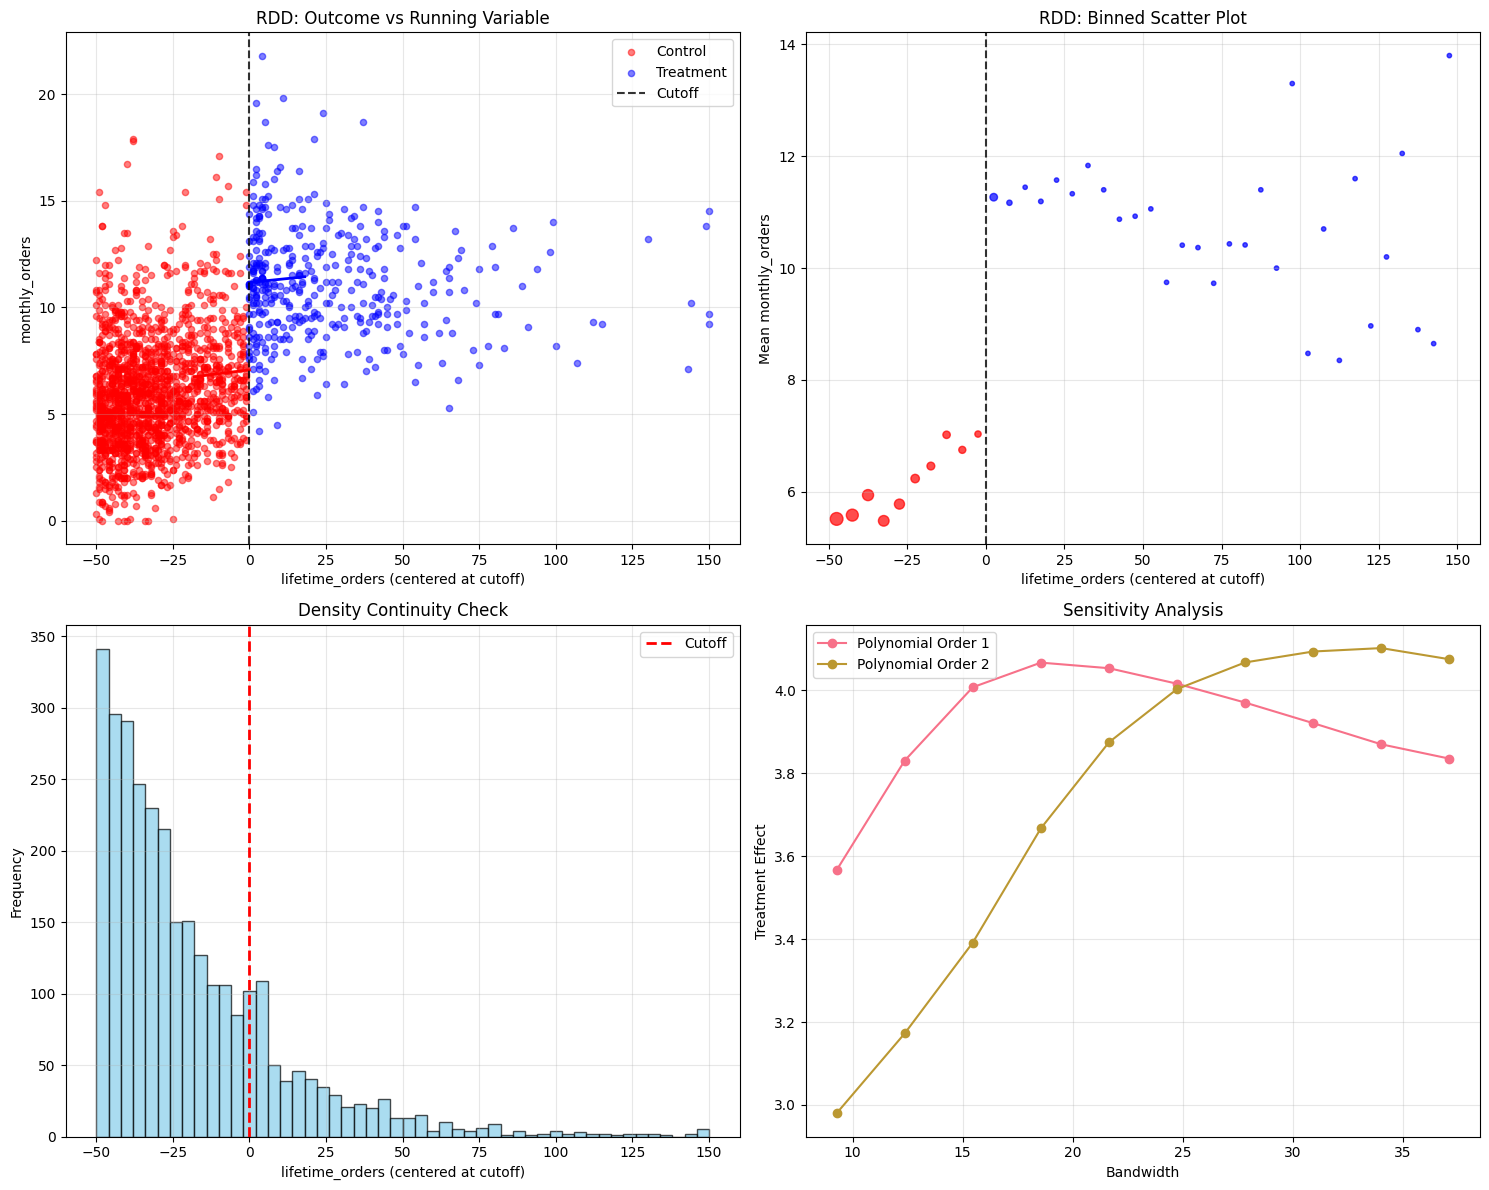

💡 How to read these plots:
  📊 Top Left: Raw data with fitted regression lines
     • Look for clear jump at cutoff (vertical line)
     • Lines should be smooth on either side
  📊 Top Right: Binned averages for cleaner view
     • Should show clear discontinuity at cutoff
  📊 Bottom Left: Density check for manipulation
     • Should be smooth across cutoff
  📊 Bottom Right: Sensitivity analysis
     • Estimates should be stable across bandwidths


In [12]:
print("📊 COMPREHENSIVE RDD VISUALIZATION")
print("=" * 50)

# Create the full RDD plot
rdd_analysis.plot_rdd(bandwidth=optimal_bandwidth, bins=40)

print("💡 How to read these plots:")
print("  📊 Top Left: Raw data with fitted regression lines")
print("     • Look for clear jump at cutoff (vertical line)")
print("     • Lines should be smooth on either side")
print("  📊 Top Right: Binned averages for cleaner view")
print("     • Should show clear discontinuity at cutoff")
print("  📊 Bottom Left: Density check for manipulation")
print("     • Should be smooth across cutoff")
print("  📊 Bottom Right: Sensitivity analysis")
print("     • Estimates should be stable across bandwidths")

In [13]:
print("🔬 TESTING ALTERNATIVE OUTCOMES")
print("=" * 50)

print("Testing RDD on other outcomes to understand full impact of auto-enrollment.")

# Test effect on average order value
print("\n1️⃣ EFFECT ON AVERAGE ORDER VALUE:")
aov_rdd = RegressionDiscontinuityDesign(
    data=df,
    outcome_var='avg_order_value',
    running_var='lifetime_orders',
    cutoff=50
)

aov_effect = aov_rdd.estimate_rdd_effect(bandwidth=optimal_bandwidth)
print(f"   Effect on AOV: ${aov_effect['treatment_effect']:+.2f} (p={aov_effect['p_value']:.3f})")

# Test effect on customer satisfaction
print("\n2️⃣ EFFECT ON CUSTOMER SATISFACTION:")
satisfaction_rdd = RegressionDiscontinuityDesign(
    data=df,
    outcome_var='customer_satisfaction',
    running_var='lifetime_orders', 
    cutoff=50
)

satisfaction_effect = satisfaction_rdd.estimate_rdd_effect(bandwidth=optimal_bandwidth)
print(f"   Effect on satisfaction: {satisfaction_effect['treatment_effect']:+.2f} points (p={satisfaction_effect['p_value']:.3f})")

# Summary of all effects
print(f"\n📊 COMPLETE IMPACT SUMMARY:")
print(f"  • Monthly orders: {rdd_effect['treatment_effect']:+.2f} ({'✓' if rdd_effect['p_value'] < 0.05 else '✗'})")
print(f"  • Average order value: ${aov_effect['treatment_effect']:+.2f} ({'✓' if aov_effect['p_value'] < 0.05 else '✗'})")
print(f"  • Customer satisfaction: {satisfaction_effect['treatment_effect']:+.2f} points ({'✓' if satisfaction_effect['p_value'] < 0.05 else '✗'})")

🔬 TESTING ALTERNATIVE OUTCOMES
Testing RDD on other outcomes to understand full impact of auto-enrollment.

1️⃣ EFFECT ON AVERAGE ORDER VALUE:
✅ RDD data validation passed
  - Total observations: 3,000
  - Running variable range: [0.00, 200.00]
  - Cutoff: 50
  - Treatment units: 614
  - Control units: 2,386

RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 18.551
RDD estimation results:
  Treatment effect: 2.321
  Standard error: 0.463
  t-statistic: 5.009
  p-value: 0.000
  95% CI: [1.413, 3.228]
  Observations used: 782
✅ STATISTICALLY SIGNIFICANT at 5% level
   Effect on AOV: $+2.32 (p=0.000)

2️⃣ EFFECT ON CUSTOMER SATISFACTION:
✅ RDD data validation passed
  - Total observations: 3,000
  - Running variable range: [0.00, 200.00]
  - Cutoff: 50
  - Treatment units: 614
  - Control units: 2,386

RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 18.551
RDD estimation results:
  Treatment effect: 0.335
  Standard error: 0.049
  t-statistic: 6.876
  p-value: 0.000
  